In [1]:
# Libraries 
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import re
import warnings
from itertools import combinations

# Evaluar linealidad de las relaciones entre las variables y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import kstest, shapiro, mannwhitneyu, spearmanr, pearsonr, chi2_contingency

# Configuration
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/df_final.csv")

In [17]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'adr_category',
       'total_nights', 'arrival_date'],
      dtype='object')

## Hipótesis y recomendaciones:

1. ¿Cuál es la tasa de cancelación de este hotel?
- Hipótesis: La tasa de cancelación es superior al 20% del total de reservas.
    - H0: La tasa de cancelación es <= 20%
    - H1: La tasa de cancelación es > 20%
- Recomendación: La tasa es ALTA, el hotel debe analizar las políticas de cancelación y las condiciones de la reserva: mayor anticipación para cancelaciones sin penalización, ofrecer seguros...

In [8]:
cancel_rate = df['is_canceled'].mean()
print(f"Tasa de cancelación: {cancel_rate*100:.2f}%")

# Datos observados
count_cancellations = df['is_canceled'].sum()  # Total de cancelaciones
total_reservations = len(df)  # Total de reservas
count_not_canceled = total_reservations - count_cancellations  # Total de no canceladas

# Tasa esperada del 20%
expected_cancel_rate = 0.2
expected_not_cancel_rate = 1 - expected_cancel_rate

# Número esperado de cancelaciones y no cancelaciones
expected_cancellations = expected_cancel_rate * total_reservations
expected_not_cancellations = expected_not_cancel_rate * total_reservations

# Tabla de contingencia
observed = np.array([count_cancellations, count_not_canceled])
expected = np.array([expected_cancellations, expected_not_cancellations])

# Prueba chi-cuadrado
stat, p_value, _, _ = chi2_contingency([observed, expected])

# Nivel de significancia
alpha = 0.05

if p_value < alpha:
    print(f"Rechazamos la H0: la tasa de cancelación observada es significativamente diferente del 20%. p-value: {p_value}")
else:
    print(f"No rechazamos la H0: no hay evidencia de que la tasa de cancelación observada sea diferente del 20%. p-value: {p_value}")


Tasa de cancelación: 36.45%
Rechazamos la H0: la tasa de cancelación observada es significativamente diferente del 20%. p-value: 0.0


2. ¿Ha cambiado la tasa de cancelación con el tiempo?
- Hipótesis: 
    - H0: La tasa de cancelación no ha cambiado con el tiempo 
    - H1: La tasa de cancelación ha aumentado/disminuido con el tiempo
- Recomendación: Ha disminuido. 

arrival_date
2015    0.399294
2016    0.358001
2017    0.351195
Name: is_canceled, dtype: float64


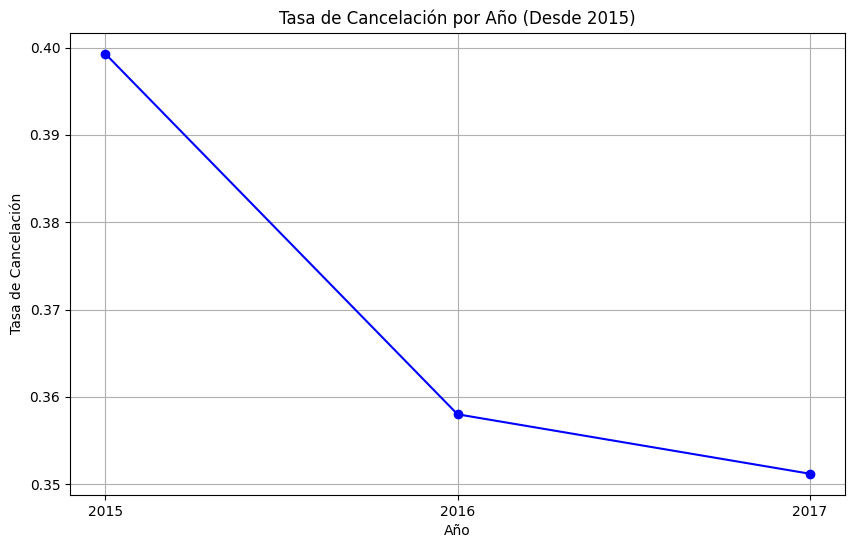

In [14]:
# Filtrar los datos desde 2015 en adelante
df_filtered = df[df['arrival_date'].dt.year >= 2015]

# Agrupar por año y calcular la tasa de cancelación promedio
cancel_rate_by_year = df_filtered.groupby(df_filtered['arrival_date'].dt.year)['is_canceled'].mean()

# Mostrar la tasa de cancelación por año
print(cancel_rate_by_year)

# Visualizar la tasa de cancelación a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(cancel_rate_by_year.index, cancel_rate_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Tasa de Cancelación por Año (Desde 2015)')
plt.xlabel('Año')
plt.ylabel('Tasa de Cancelación')
plt.grid(True)
plt.xticks(cancel_rate_by_year.index)  # Mostrar todos los años en el eje x
plt.show()


In [23]:
df_filtered = df[df['arrival_date'].dt.year >= 2015]

# Agrupar por año y calcular la tasa de cancelación promedio
cancel_rate_by_year = df_filtered.groupby(df_filtered['arrival_date'].dt.year)['is_canceled'].mean()

# Convertir índices de años a una columna para análisis de Spearman
years = cancel_rate_by_year.index
cancel_rates = cancel_rate_by_year.values

# Realizar el test de correlación de Spearman
rho, p_value = spearmanr(years, cancel_rates)

# Nivel de significancia
alpha = 0.05

# Evaluar la hipótesis
print(f"Rho (coeficiente de Spearman): {rho}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Rechazamos la H0: Hay una correlación significativa entre el año y la tasa de cancelación.")
else:
    print("No rechazamos la H0: No hay evidencia de una correlación significativa entre el año y la tasa de cancelación.")


Rho (coeficiente de Spearman): -1.0
P-value: 0.0
Rechazamos la H0: Hay una correlación significativa entre el año y la tasa de cancelación.


3. ¿Existen diferencias en la tasa de cancelación según la temporada o los días de la semana?
- Hipótesis: 
    - H0: No existen diferencias en la tasa de cancelación según temporada o los días de la semana.
    - H1: La tasa de cancelación es mayor en ciertas temporadas (verano/invierno) o días de la semana (fines de semana entre semana).
- Recomendación: Si es mayor en ciertos períodos (Verano), considerar ajustar precios o políticas para fomentar reservas más seguras.

In [32]:
# cancelaciones por temporada (verano/invierno)
df['season'] = df['arrival_date_month'].apply(lambda x: 'verano' if x in [6, 7, 8] else ('invierno' if x in [12, 1, 2] else 'entre temporada'))
cancel_rate_by_season = df.groupby('season')['is_canceled'].mean()
print(cancel_rate_by_season)


# tabla de contingencia
contingency_table_season = pd.crosstab(df['season'], df['is_canceled'])

# prueba Chi-cuadrado
chi2, p_value, _, _ = chi2_contingency(contingency_table_season)

if p_value < alpha:
    print("Rechazamos H0: Hay una diferencia significativa en la tasa de cancelación entre las temporadas.")
else:
    print("No hay evidencia de diferencias significativas en la tasa de cancelación entre las temporadas.")


season
entre temporada    0.367194
invierno           0.323955
verano             0.382706
Name: is_canceled, dtype: float64
Rechazamos H0: Hay una diferencia significativa en la tasa de cancelación entre las temporadas.


4. ¿Qué factores demográficos están asociados con una mayor probabilidad de cancelación? (País)

- Hipótesis: 
    - H0: No hay diferencia en la tasa de cancelación entre países 
    - H1: Clientes de ciertos países tienen una mayor tasa de cancelación.
- Recomendación: Desarrollar estrategias dirigidas a cada país con tasa de cancelación alta, como seguros de cancelación o promociones para incentivar la confirmación.

In [35]:
# tasa de cancelación promedio por país 
cancel_rate_by_country = df.groupby('country')['is_canceled'].mean()

# país con la tasa de cancelación más alta y la más baja
country_highest = cancel_rate_by_country.idxmax()
country_lowest = cancel_rate_by_country.idxmin()

rate_highest = cancel_rate_by_country.max()
rate_lowest = cancel_rate_by_country.min()

print(f"País con la tasa de cancelación más alta: {country_highest} ({rate_highest*100:.2f}%)")
print(f"País con la tasa de cancelación más baja: {country_lowest} ({rate_lowest*100:.2f}%)")

# tabla contingencia por país
contingency_table_country = pd.crosstab(df['country'], df['is_canceled'])

# prueba Chi-cuadrado
chi2, p_value, _, _ = chi2_contingency(contingency_table_country)

if p_value < alpha:
    print("Hay una diferencia significativa en la tasa de cancelación entre países.")
else:
    print("No hay evidencia de diferencias significativas en la tasa de cancelación entre países.")


País con la tasa de cancelación más alta: AND (100.00%)
País con la tasa de cancelación más baja: ABW (0.00%)
Hay una diferencia significativa en la tasa de cancelación entre países.


5. Cómo afecta el tiempo de anticipación de la reserva (lead time) a la probabilidad de cancelación?
- Hipótesis: 
 - H0: El tiempo de anticipación no afecta en la cancelación.
 - H1: Las reservas con mayor lead time tienen una mayor probabilidad de cancelación.
- Recomendación: Implementar incentivos o restricciones para reservas con mucho tiempo de anticipación.

In [53]:
from scipy.stats import ttest_ind

# dos grupos: cancelaciones y no cancelaciones
lead_time_canceled = df[df['is_canceled'] == 1]['lead_time']
lead_time_not_canceled = df[df['is_canceled'] == 0]['lead_time']

# Prueba t de Student
stat, p_value = ttest_ind(lead_time_canceled, lead_time_not_canceled)

if p_value < alpha:
    print("Se descarta la H0: Hay una diferencia significativa en el tiempo de anticipación entre cancelaciones y no cancelaciones.")
else:
    print("No hay evidencia de diferencias significativas en el tiempo de anticipación.")


Se descarta la H0: Hay una diferencia significativa en el tiempo de anticipación entre cancelaciones y no cancelaciones.


6. ¿Las reservas que incluyen hijos tienen un riesgo menor/mayor de cancelación?
- Hipótesis: 
- H0: No existe un riesgo significativo en las reservas que incluyen hijos. 
- H1: Las reservas que incluyen hijos tienen menos/más probabilidad de ser canceladas.
- Recomendación: Ofrecer paquetes familiares que refuercen la reserva y seguridad de asistencia.

In [56]:

df['has_children_or_babies'] = (df['children'] > 0) | (df['babies'] > 0)

contingency_table_children_babies = pd.crosstab(df['has_children_or_babies'], df['is_canceled'])

print("Tabla de contingencia para reservas con y sin hijos/bebés:")
print(contingency_table_children_babies)

total_with_children_or_babies = contingency_table_children_babies.loc[True].sum()
total_without_children_or_babies = contingency_table_children_babies.loc[False].sum()

cancelled_with_children_or_babies = contingency_table_children_babies.loc[True, True] if True in contingency_table_children_babies.columns else 0
cancelled_without_children_or_babies = contingency_table_children_babies.loc[False, True] if True in contingency_table_children_babies.columns else 0

cancel_rate_with_children_or_babies = cancelled_with_children_or_babies / total_with_children_or_babies if total_with_children_or_babies > 0 else 0
cancel_rate_without_children_or_babies = cancelled_without_children_or_babies / total_without_children_or_babies if total_without_children_or_babies > 0 else 0

print(f"Tasa de cancelación para reservas con hijos o bebés: {cancel_rate_with_children_or_babies * 100:.2f}%")
print(f"Tasa de cancelación para reservas sin hijos ni bebés: {cancel_rate_without_children_or_babies * 100:.2f}%")

#prueba Chi-cuadrado
chi2, p_value, _, _ = chi2_contingency(contingency_table_children_babies)

alpha = 0.05

if p_value < alpha:
    print("Se descarta la H0: La tasa de cancelación para reservas con hijos o bebés es menor.")
else:
    print("No hay evidencia de diferencias significativas en la tasa de cancelación para reservas con hijos o bebés.")


Tabla de contingencia para reservas con y sin hijos/bebés:
is_canceled             False  True 
has_children_or_babies              
False                   70949  40950
True                     3918   1999
Tasa de cancelación para reservas con hijos o bebés: 33.78%
Tasa de cancelación para reservas sin hijos ni bebés: 36.60%
Se descarta la H0: La tasa de cancelación para reservas con hijos o bebés es menor.


7. ¿Los usuarios que realizaron algún cambio en su reserva tienen menor riesgo de cancelación?
- Hipótesis: 
    - H0: Los usuarios que realizaron cambios en sus reservas no tienen una menor tasa de cancelación.
    - H1: Los usuarios que realizaron cambios en sus reservas tienen una menor tasa de cancelación. 

- Recomendación: Fomentar la flexibilidad en las reservas para que los usuarios puedan modificar en lugar de cancelar.

In [57]:
# Crear tabla de contingencia para cambios en la reserva
contingency_table_changes = pd.crosstab(df['booking_changes'] > 0, df['is_canceled'])

# Prueba Chi-cuadrado
chi2, p_value, _, _ = chi2_contingency(contingency_table_changes)

if p_value < alpha:
    print("Se rechaza la H0: Hay una menor tasa de cancelación cuando se realizan cambios en la reserva.")
else:
    print("No hay evidencia de diferencias significativas en la tasa de cancelación según cambios en la reserva.")


Se rechaza la H0: Hay una menor tasa de cancelación cuando se realizan cambios en la reserva.


8. ¿El riesgo de cancelación es menor cuando el usuario ha realizado una solicitud especial?

- Hipótesis: 
    - H0: Las reservas con solicitudes especiales no tienen menor riesgo de cancelación.
    - H1: Las reservas con solicitudes especiales tienen menor riesgo de cancelación. 

- Recomendación: Incentivar a los usuarios a realizar solicitudes especiales como una estrategia para reducir las cancelaciones.

In [59]:
# Crear tabla de contingencia para solicitudes especiales
contingency_table_special_requests = pd.crosstab(df['total_of_special_requests'] > 0, df['is_canceled'])

# Prueba Chi-cuadrado
chi2, p_value, _, _ = chi2_contingency(contingency_table_special_requests)

if p_value < alpha:
    print("Se rechaza la H0: la tasa de cancelación es menor cuando se hacen solicitudes especiales.")
else:
    print("No hay evidencia de diferencias significativas en la tasa de cancelación según solicitudes especiales.")


Se rechaza la H0: la tasa de cancelación es menor cuando se hacen solicitudes especiales.


9. ¿Las reservas con un ADR bajo tienen un riesgo menor de cancelación?

- Hipótesis: 
    - H0: Las reservas con un ADR (Average Daily Rate) más bajo no tienen menor probabilidad de cancelación.
    - H1: Las reservas con un ADR (Average Daily Rate) más bajo tienen menor probabilidad de cancelación.

- Recomendación: Ofrecer tarifas especiales o descuentos para reducir el riesgo de cancelaciones, especialmente en temporadas bajas.

In [61]:
# Prueba t para comparar ADR en cancelaciones y no cancelaciones
adr_canceled = df[df['is_canceled'] == 1]['adr']
adr_not_canceled = df[df['is_canceled'] == 0]['adr']

# Prueba t de Student
stat, p_value = ttest_ind(adr_canceled, adr_not_canceled)

if p_value < alpha:
    print("Se rechaza la H0: hay una diferencia significativa en el ADR entre reservas canceladas y no canceladas.")
else:
    print("No hay evidencia de diferencias significativas en el ADR entre reservas canceladas y no canceladas.")


Se rechaza la H0: hay una diferencia significativa en el ADR entre reservas canceladas y no canceladas.


10. ¿Qué otros factores están asociados con una mayor probabilidad de cancelación?

- Hipótesis: 
    - H0: Factores como el tipo de comida incluida, el número de solicitudes especiales, las políticas de cancelación, o la disponibilidad de habitaciones no afectan la probabilidad de cancelación.
    - H1: Factores como el tipo de comida incluida, el número de solicitudes especiales, las políticas de cancelación, o la disponibilidad de habitaciones afectan la probabilidad de cancelación.

- Recomendación: Evaluar y ajustar las políticas de reserva y cancelación para optimizar la ocupación y minimizar cancelaciones.

In [65]:
variables_continuas = ['total_of_special_requests', 'adr', 'required_car_parking_spaces']
df_continuas = df[variables_continuas + ['is_canceled']]

# correlación de Spearman entre la tasa de cancelación y las variables continuas
for variable in variables_continuas:
    correlation, p_value = spearmanr(df_continuas[variable], df_continuas['is_canceled'])
    print(f"Correlación de Spearman entre '{variable}' y la tasa de cancelación: {correlation:.3f}")
    print(f"P-valor: {p_value:.4f}")
    
    if p_value < alpha:
        print("Se rechaza H0: Hay una relación significativa entre esta variable y la tasa de cancelación.")
    else:
        print("No hay evidencia de una relación significativa entre esta variable y la tasa de cancelación.")
    print("\n")


Correlación de Spearman entre 'total_of_special_requests' y la tasa de cancelación: -0.251
P-valor: 0.0000
Se rechaza H0: Hay una relación significativa entre esta variable y la tasa de cancelación.


Correlación de Spearman entre 'adr' y la tasa de cancelación: 0.055
P-valor: 0.0000
Se rechaza H0: Hay una relación significativa entre esta variable y la tasa de cancelación.


Correlación de Spearman entre 'required_car_parking_spaces' y la tasa de cancelación: -0.196
P-valor: 0.0000
Se rechaza H0: Hay una relación significativa entre esta variable y la tasa de cancelación.




In [67]:
variables_categoricas = ['meal', 'market_segment', 'distribution_channel']
alpha = 0.05

for variable in variables_categoricas:
    contingency_table = pd.crosstab(df[variable], df['is_canceled'])
    print(f"Tabla de contingencia para '{variable}':")
    print(contingency_table)
    
    # prueba Chi-cuadrado
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"\nChi-cuadrado para '{variable}': {chi2:.3f}")
    print(f"P-valor: {p_value:.4f}")
    
    if p_value < alpha:
        print("Se rechaza H0: Hay una diferencia significativa en la tasa de cancelación para esta variable categórica.")
    else:
        print("No hay evidencia de diferencias significativas en la tasa de cancelación para esta variable categórica.")
    print("\n")

Tabla de contingencia para 'meal':
is_canceled  False  True 
meal                     
BB           57641  33395
FB             316    461
HB            9360   4860
SC            6681   3959
Undefined      869    274

Chi-cuadrado para 'meal': 288.916
P-valor: 0.0000
Se rechaza H0: Hay una diferencia significativa en la tasa de cancelación para esta variable categórica.


Tabla de contingencia para 'market_segment':
is_canceled     False  True 
market_segment              
Aviation           94     24
Complementary     320     43
Corporate        4447   1106
Direct          10688   2090
Groups           3758   5794
Offline TA/TO    7875   3945
Online TA       17872  10439
TA/TO           25561  17021
Undefined           0      1

Chi-cuadrado para 'market_segment': 5688.763
P-valor: 0.0000
Se rechaza H0: Hay una diferencia significativa en la tasa de cancelación para esta variable categórica.


Tabla de contingencia para 'distribution_channel':
is_canceled           False  True 
distri

## RECOMENDACIONES GENERALES -CONCLUSIONES FINALES-

- Optimización de la Estrategia de Precios: Ajustar las políticas de precios y ofertas especiales basándote en las variables que muestran una relación significativa con la tasa de cancelación.
- Implementar descuentos para reservas anticipadas, ofertas de último minuto o precios más flexibles puede ayudar a reducir las cancelaciones.

- Mejorar la Experiencia del Cliente: Asegurarse de que los clientes que hacen solicitudes especiales reciban un servicio excepcional. 
- Crear un programa de fidelidad que premie a los clientes que no cancelan y a aquellos que hacen solicitudes especiales, incentivando así la lealtad.

- Revisión de Políticas de Cancelación: Basándose en las variables asociadas con una mayor tasa de cancelación, ajustar las políticas de cancelación. Por ejemplo, si ciertos tipos de paquetes   tienen una alta tasa de cancelación, se podría considerar ajustar los términos de cancelación para estos paquetes o introducir opciones de cancelación más flexibles.

- Personalización del Marketing: Utilizar los resultados del análisis para personalizar las campañas de marketing. 
- Ofrecer promociones dirigidas a segmentos con alta tasa de cancelación y comunicar claramente las políticas de cancelación y las ofertas disponibles para minimizar el riesgo de cancelación.